## *Varying dropout rates: Ablation study*

Vary dropout rates as 0.5 and 0.6 each. 

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from tqdm import tqdm


from gensim.models import KeyedVectors

In [ ]:
TRAIN_PATH = '/kaggle/input/bias-of-us-news-media-houses/Train.xlsx'

def clean_text(text: str) -> str:
    """Clean the input text by removing URLs, 'RT', special characters, and extra whitespace."""
    text = re.sub(r"http\S+", " ", text)  
    text = re.sub(r"RT ", " ", text)       
    text = re.sub(r"[^a-zA-Z\'\.\,\d\s]", " ", text)  
    text = re.sub(r'\t', ' ', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def load_and_preprocess_data(path: str) -> pd.DataFrame:
    df = pd.read_excel(path, engine='openpyxl')
    for col in ['content_original', 'title']:
        df[col] = df[col].str.split(' \n\n---\n\n').str[0]
        df[col] = (df[col]
                   .str.replace('-', ' ')
                   .str.replace('[^\w\s]', '', regex=True)
                   .str.replace('\n', ' ')
                   .str.lower())
        df[col] = df[col].apply(clean_text)
    return df

# Load and preview the data
df_train = load_and_preprocess_data(TRAIN_PATH)
df_train.head(2)


,Unnamed: 0,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID
0,0,immigration,National Review,2,https://www.nationalreview.com/2018/12/governm...,shutdown theater again,2018-12-12,"Kevin D. Williamson, Kyle Smith, Andrew C. Mcc...",President Trump and Senate Minority Leader Chu...,president trump and senate minority leader chu...,www.nationalreview.com,right,zl7kc7EmAyIdUMIo
1,1,culture,Yahoo! The 360,1,https://news.yahoo.com/can-the-developing-worl...,can the developing world endure the coronavirus,2020-06-30,Mike Bebernes,“ The 360 ” shows you diverse perspectives on ...,the 360 shows you diverse perspectives on the ...,www.news.yahoo.com,center,xpbjYTJYPdlw6HmJ


In [ ]:
word2vec_model_path = '/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin'
cached_kv_path = 'word2vec_model.kv'

if os.path.exists(cached_kv_path):
    print("Loading cached Word2Vec model...")
    w2v_model = KeyedVectors.load(cached_kv_path, mmap='r')
else:
    print("Loading Word2Vec model from binary file (this may take several minutes)...")
    w2v_model = KeyedVectors.load_word2vec_format(word2vec_model_path, binary=True)
    print("Saving cached version...")
    w2v_model.save(cached_kv_path)

UNK_TOKEN = "<unk>"
UNK_INDEX = 0
word2vec_vocab = {word: idx + 1 for word, idx in w2v_model.key_to_index.items()}
vocab_size = len(word2vec_vocab) + 1
embedding_dim = w2v_model.vector_size 

embedding_matrix = torch.zeros(vocab_size, embedding_dim)
for word, idx in word2vec_vocab.items():
    embedding_matrix[idx] = torch.tensor(w2v_model[word])
    
print(f"Word2Vec embeddings loaded: vocab size = {vocab_size}, embedding dim = {embedding_dim}")


Loading Word2Vec model from binary file (this may take several minutes)...
Saving cached version...
Word2Vec embeddings loaded: vocab size = 3000001, embedding dim = 300


In [4]:
def basic_tokenizer(text: str) -> list:
    """Tokenize text by splitting on whitespace."""
    return text.split()

def tokenize_and_pad(text: str, max_len: int) -> torch.Tensor:
    """
    Tokenizes the input text and converts tokens to indices using the Word2Vec vocabulary.
    Unknown tokens are assigned index 0. The sequence is padded or truncated to max_len.
    """
    tokens = basic_tokenizer(text)
    indices = [word2vec_vocab.get(token, UNK_INDEX) for token in tokens]
    padded = indices[:max_len] + [0] * max(0, max_len - len(indices))
    return torch.tensor(padded)


In [ ]:
class BiasDataset(Dataset):
    def __init__(self, data: pd.DataFrame, max_sentence_length: int):
        self.data = data.reset_index(drop=True)
        self.max_sentence_length = max_sentence_length

    def __len__(self) -> int:
        return len(self.data)
  
    def __getitem__(self, index: int) -> dict:
        row = self.data.iloc[index]
        body = tokenize_and_pad(row['content_original'], self.max_sentence_length)
        title = tokenize_and_pad(row['title'], self.max_sentence_length)
    
        label = torch.tensor(row['bias'], dtype=torch.long)
        return {"body": body, "title": title, "labels": label}

class BiasDataModule(pl.LightningDataModule):
    def __init__(self, train_df: pd.DataFrame, val_df: pd.DataFrame, max_sentence_length: int, batch_size: int):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.max_sentence_length = max_sentence_length
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = BiasDataset(self.train_df, self.max_sentence_length)
        self.val_dataset = BiasDataset(self.val_df, self.max_sentence_length)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          shuffle=True, num_workers=4, drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=4, drop_last=False)

train_df, val_df = train_test_split(df_train, test_size=0.2, random_state=42)
print("Train shape:", train_df.shape, "Val shape:", val_df.shape)

BATCH_SIZE = 1024
MAX_LEN = 120  
data_module = BiasDataModule(train_df, val_df, max_sentence_length=MAX_LEN, batch_size=BATCH_SIZE)
data_module.setup()


Train shape: (21272, 13) Val shape: (5318, 13)


In [ ]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchmetrics

class LitBiasModel_NoMHA(pl.LightningModule):
    def __init__(self, embedding_matrix: torch.Tensor, num_classes: int,
                 embed_dim: int, hidd_dim: int, num_layers: int = 2, 
                 dropout_rate: float = 0.4, lr: float = 1e-3):
        super().__init__()
        self.save_hyperparameters(ignore=["embedding_matrix"])
        
        # Frozen embedding layer using pretrained Word2Vec embeddings
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        
        # Shared bidirectional LSTM layer with dropout
        self.bilstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidd_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate,
            bidirectional=True
        )
        
        # Classification head (feedforward network) with dropout
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.ReLU(),
            nn.Linear(hidd_dim, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout_rate),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.Dropout(dropout_rate),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
        
        self.loss_fn = nn.CrossEntropyLoss()
        self.train_acc = torchmetrics.Accuracy(num_classes=num_classes, task="multiclass")
        self.val_acc = torchmetrics.Accuracy(num_classes=num_classes, task="multiclass")
        self._train_losses = []
        self._val_losses = []
        self.train_history = {"acc": [], "loss": []}
        self.val_history = {"acc": [], "loss": []}

    def forward(self, title: torch.Tensor, body: torch.Tensor) -> torch.Tensor:
        # Obtain embeddings
        title_embed = self.embedding(title)
        body_embed = self.embedding(body)
        
        # Shared bidirectional LSTM for title and body separately
        _, (title_hidden, _) = self.bilstm(title_embed)
        _, (body_hidden, _) = self.bilstm(body_embed)
        
        # Aggregate hidden states by mean pooling over layers
        title_repr = title_hidden.permute(1, 0, 2).mean(dim=1)
        body_repr = body_hidden.permute(1, 0, 2).mean(dim=1)
        
        # Fuse the representations
        aggregated = (title_repr + body_repr) / 2
        
        logits = self.classifier(aggregated)
        return logits

    def training_step(self, batch, batch_idx):
        logits = self.forward(batch["title"], batch["body"])
        loss = self.loss_fn(logits, batch["labels"])
        self._train_losses.append(loss)
        self.train_acc.update(logits, batch["labels"])
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        logits = self.forward(batch["title"], batch["body"])
        loss = self.loss_fn(logits, batch["labels"])
        self._val_losses.append(loss)
        self.val_acc.update(logits, batch["labels"])
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        avg_loss = torch.stack(self._train_losses).mean() if self._train_losses else torch.tensor(0.0, device=self.device)
        train_acc = self.train_acc.compute()
        self.train_history["loss"].append(avg_loss.item())
        self.train_history["acc"].append(train_acc.item())
        self.log_dict({"Epoch_Train_Loss": avg_loss, "Epoch_Train_Acc": train_acc}, prog_bar=True)
        print(f"Train - Acc: {train_acc:.4f}, Loss: {avg_loss:.4f}")
        self.train_acc.reset()
        self._train_losses.clear()

    def on_validation_epoch_end(self):
        avg_loss = torch.stack(self._val_losses).mean() if self._val_losses else torch.tensor(0.0, device=self.device)
        val_acc = self.val_acc.compute()
        self.val_history["loss"].append(avg_loss.item())
        self.val_history["acc"].append(val_acc.item())
        self.log_dict({"Epoch_Val_Loss": avg_loss, "Epoch_Val_Acc": val_acc}, prog_bar=True)
        print(f"Val - Acc: {val_acc:.4f}, Loss: {avg_loss:.4f}")
        self.val_acc.reset()
        self._val_losses.clear()

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)

dropout_rates = [0.5, 0.6]  





In [7]:
for dropout in dropout_rates:
    print(f"Training Dropout {dropout}")
    
    # Unique logger for each dropout model
    logger = TensorBoardLogger("tb_logs", name=f"lit_bias_model_dropout_{dropout}")
    
    # Create and train model
    model = LitBiasModel_NoMHA(
        embedding_matrix=embedding_matrix,
        num_classes=3,
        embed_dim=300,
        hidd_dim=200,
        num_layers=2,
        dropout_rate=dropout,
        lr=1e-3
    )
    
    trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        max_epochs=20,
        logger=logger,
        log_every_n_steps=10
    )
    
    trainer.fit(model, data_module)

Training Dropout 0.5


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.2852, Loss: 1.1249


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.2824, Loss: 1.1032
Train - Acc: 0.3271, Loss: 1.1832


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.4143, Loss: 1.0863
Train - Acc: 0.3700, Loss: 1.1185


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.4831, Loss: 1.0408
Train - Acc: 0.4455, Loss: 1.0470


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.5967, Loss: 0.8792
Train - Acc: 0.5299, Loss: 0.9615


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.3394, Loss: 1.7154
Train - Acc: 0.6042, Loss: 0.8920


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6484, Loss: 0.7809
Train - Acc: 0.6226, Loss: 0.8554


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6544, Loss: 0.7692
Train - Acc: 0.6704, Loss: 0.7929


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6978, Loss: 0.7038
Train - Acc: 0.6863, Loss: 0.7599


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7044, Loss: 0.7200
Train - Acc: 0.7170, Loss: 0.7141


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6557, Loss: 0.9626
Train - Acc: 0.7251, Loss: 0.6894


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7262, Loss: 0.6418
Train - Acc: 0.7359, Loss: 0.6652


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6986, Loss: 0.7427
Train - Acc: 0.7188, Loss: 0.7165


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7381, Loss: 0.6235
Train - Acc: 0.7470, Loss: 0.6489


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7317, Loss: 0.6190
Train - Acc: 0.7679, Loss: 0.6103


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7450, Loss: 0.6017
Train - Acc: 0.7752, Loss: 0.5924


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7394, Loss: 0.6146
Train - Acc: 0.7857, Loss: 0.5674


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7518, Loss: 0.6090
Train - Acc: 0.7932, Loss: 0.5557


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7516, Loss: 0.6051
Train - Acc: 0.8036, Loss: 0.5329


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7535, Loss: 0.6427
Train - Acc: 0.8047, Loss: 0.5268


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7281, Loss: 0.6420
Train - Acc: 0.8098, Loss: 0.5141
Training Dropout 0.6


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.3867, Loss: 1.1004


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.3800, Loss: 1.0990
Train - Acc: 0.3446, Loss: 1.1819


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.3800, Loss: 1.0924
Train - Acc: 0.3672, Loss: 1.1331


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.4430, Loss: 1.0641
Train - Acc: 0.4124, Loss: 1.0789


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.4816, Loss: 0.9944
Train - Acc: 0.4637, Loss: 1.0265


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6115, Loss: 0.9068
Train - Acc: 0.5122, Loss: 0.9805


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6219, Loss: 0.8505
Train - Acc: 0.5735, Loss: 0.9306


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6493, Loss: 0.8069
Train - Acc: 0.6183, Loss: 0.8759


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.5936, Loss: 0.8675
Train - Acc: 0.6562, Loss: 0.8253


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6625, Loss: 0.7900
Train - Acc: 0.6727, Loss: 0.7969


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6382, Loss: 0.7827
Train - Acc: 0.6741, Loss: 0.7840


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6758, Loss: 0.7294
Train - Acc: 0.7027, Loss: 0.7367


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6909, Loss: 0.7026
Train - Acc: 0.7233, Loss: 0.7093


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6963, Loss: 0.7041
Train - Acc: 0.7061, Loss: 0.7222


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7339, Loss: 0.6375
Train - Acc: 0.7281, Loss: 0.6797


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7236, Loss: 0.6455
Train - Acc: 0.7540, Loss: 0.6402


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7486, Loss: 0.6047
Train - Acc: 0.7628, Loss: 0.6190


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7450, Loss: 0.6157
Train - Acc: 0.7707, Loss: 0.6082


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7396, Loss: 0.6473
Train - Acc: 0.7766, Loss: 0.5949


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7505, Loss: 0.6283
Train - Acc: 0.7808, Loss: 0.5887


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7586, Loss: 0.5928
Train - Acc: 0.7914, Loss: 0.5680


In [ ]:
print(model.val_history)

{'acc': [0.38671875, 0.38003009557724, 0.38003009557724, 0.443023681640625, 0.4815720319747925, 0.6115080714225769, 0.621850311756134, 0.6493042707443237, 0.5936442017555237, 0.6624671220779419, 0.638209879398346, 0.6758179664611816, 0.6908612251281738, 0.6963143944740295, 0.73392254114151, 0.7235803008079529, 0.7485896944999695, 0.7450169324874878, 0.7395637631416321, 0.7504701018333435, 0.7585558295249939], 'loss': [1.1003758907318115, 1.0989909172058105, 1.0924298763275146, 1.0641052722930908, 0.9943512678146362, 0.9067971110343933, 0.8504694700241089, 0.8068645000457764, 0.8674587607383728, 0.7900218963623047, 0.7827264666557312, 0.7293792963027954, 0.7025631666183472, 0.7041077613830566, 0.6374555826187134, 0.6455458998680115, 0.6047440767288208, 0.6157321333885193, 0.6473342180252075, 0.6282997131347656, 0.5928281545639038]}


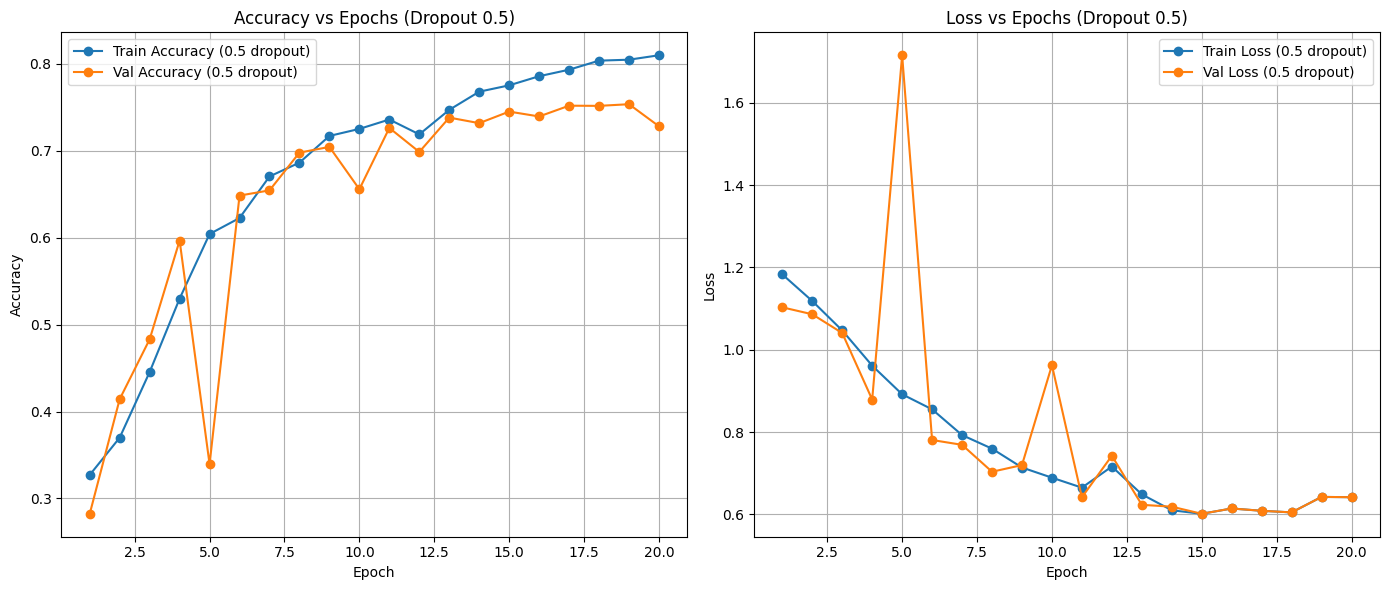

In [12]:
import matplotlib.pyplot as plt

# Data for dropout 0.5 (20 epochs)
epochs_05 = list(range(1, 21))
train_acc_05 = [0.3271, 0.3700, 0.4455, 0.5299, 0.6042, 0.6226, 0.6704, 0.6863, 0.7170, 0.7251,
                0.7359, 0.7188, 0.7470, 0.7679, 0.7752, 0.7857, 0.7932, 0.8036, 0.8047, 0.8098]
val_acc_05   = [0.2824, 0.4143, 0.4831, 0.5967, 0.3394, 0.6484, 0.6544, 0.6978, 0.7044, 0.6557,
                0.7262, 0.6986, 0.7381, 0.7317, 0.7450, 0.7394, 0.7518, 0.7516, 0.7535, 0.7281]

train_loss_05 = [1.1832, 1.1185, 1.0470, 0.9615, 0.8920, 0.8554, 0.7929, 0.7599, 0.7141, 0.6894,
                 0.6652, 0.7165, 0.6489, 0.6103, 0.6017, 0.6146, 0.6090, 0.6051, 0.6427, 0.6420]
val_loss_05   = [1.1032, 1.0863, 1.0408, 0.8792, 1.7154, 0.7809, 0.7692, 0.7038, 0.7200, 0.9626,
                 0.6418, 0.7427, 0.6235, 0.6190, 0.6017, 0.6146, 0.6090, 0.6051, 0.6427, 0.6420]



# Plotting Accuracy for dropout 0.5
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_05, train_acc_05, label='Train Accuracy (0.5 dropout)', marker='o')
plt.plot(epochs_05, val_acc_05, label='Val Accuracy (0.5 dropout)', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs (Dropout 0.5)")
plt.legend()
plt.grid(True)

# Plotting Loss for dropout 0.5
plt.subplot(1, 2, 2)
plt.plot(epochs_05, train_loss_05, label='Train Loss (0.5 dropout)', marker='o')
plt.plot(epochs_05, val_loss_05, label='Val Loss (0.5 dropout)', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs (Dropout 0.5)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



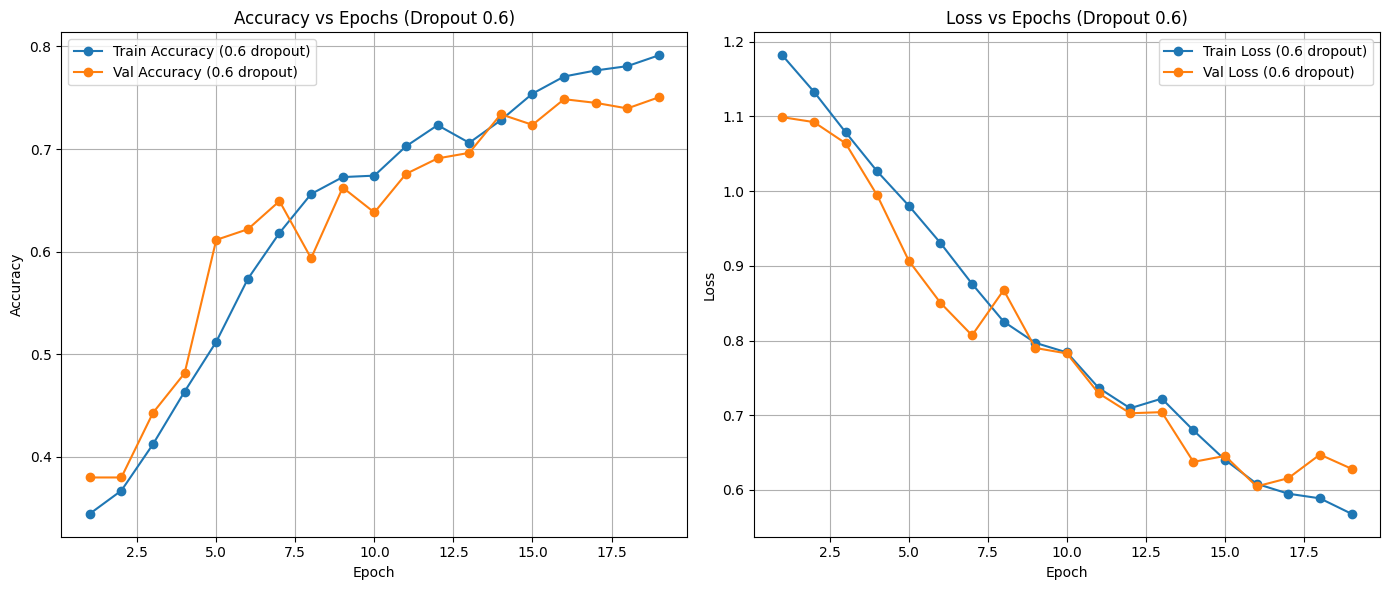

In [13]:
import matplotlib.pyplot as plt

# Data for dropout 0.6 (using the actual number of epochs in your data)
train_acc_06 = [0.3446, 0.3672, 0.4124, 0.4637, 0.5122, 0.5735, 0.6183, 0.6562, 0.6727, 0.6741,
                0.7027, 0.7233, 0.7061, 0.7281, 0.7540, 0.7707, 0.7766, 0.7808, 0.7914]
val_acc_06   = [0.3800, 0.3800, 0.4430, 0.4816, 0.6115, 0.6219, 0.6493, 0.5936, 0.6625, 0.6382,
                0.6758, 0.6909, 0.6963, 0.7339, 0.7236, 0.7486, 0.7450, 0.7396, 0.7505]
train_loss_06 = [1.1819, 1.1331, 1.0789, 1.0265, 0.9805, 0.9306, 0.8759, 0.8253, 0.7969, 0.7840,
                 0.7367, 0.7093, 0.7222, 0.6797, 0.6402, 0.6082, 0.5949, 0.5887, 0.5680]
val_loss_06   = [1.0990, 1.0924, 1.0641, 0.9944, 0.9068, 0.8505, 0.8069, 0.8675, 0.7900, 0.7827,
                 0.7294, 0.7026, 0.7041, 0.6375, 0.6455, 0.6047, 0.6157, 0.6473, 0.6283]

# Generate the epoch indices dynamically based on the length of the lists
epochs_06 = list(range(1, len(train_acc_06) + 1))

plt.figure(figsize=(14, 6))

# Plotting Accuracy for dropout 0.6
plt.subplot(1, 2, 1)
plt.plot(epochs_06, train_acc_06, label='Train Accuracy (0.6 dropout)', marker='o')
plt.plot(epochs_06, val_acc_06, label='Val Accuracy (0.6 dropout)', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs (Dropout 0.6)")
plt.legend()
plt.grid(True)

# Plotting Loss for dropout 0.6
plt.subplot(1, 2, 2)
plt.plot(epochs_06, train_loss_06, label='Train Loss (0.6 dropout)', marker='o')
plt.plot(epochs_06, val_loss_06, label='Val Loss (0.6 dropout)', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs (Dropout 0.6)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
